# Data Preparation

In [5]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [8]:
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [10]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

In [11]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 18 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,"21 days, 11 hours and 23 minutes"
H2O_cluster_name:,H2O_from_python_vickyma_rxjfot
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.601 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [12]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

# Random Forest

- Random Forest is a type of machine learning algorithm that is commonly used for both classification and regression tasks. It belongs to the ensemble learning family, which means it combines the predictions of multiple individual models to create a more robust and accurate final prediction.

- Anomaly detection is about finding instances in a dataset that deviate from the norm or behave unusually. Random Forest can be used for anomaly detection because it's good at learning the "normal" patterns in data and identifying when something doesn't fit those patterns.

### I run with a small sample dataset before building the model on the entire dataset.

In [13]:
target='loan_default'

In [14]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [16]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         108002                 6            11           7.66          19            25            22.45

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14767353573534184
RMSE: 0.38428314526575563
MAE: 0.2957980576763411
RMSLE: 0.2694211114439255
Mean Residual Deviance: 0.14767353573534184

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1477604099297664
RMSE: 0.3843961627406892
MAE: 0.29597600286172465
RMSLE: 0.26950533579774466
Mean Residual Deviance: 0.1477604099297664

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.295862  0.0105649   0.289865      0.288422      0.298811      0.300648      0.292843      0.314834      0.285189      0.299015      0.280622      0.30837
mean_residual_deviance  0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
mse                     0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
r2                      0.028792  0.0137831   0.00862054    0.0396453     0.0410812     0.0347524     0.0503409     0.0253746     0.0139032     0.0120922     0.0286377     0.0334718
residual_deviance       0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
rmse                    0.383921  0.0152529   0.375468      0.376155      0.389945      0.39179       0.382246      0.409737      0.36397       0.386362      0.362004      0.401536
rmsle                   0.269315  0.00791244  0.265959      0.264117      0.271659      0.273025      0.267234      0.283091      0.260066      0.272064      0.257598      0.278338

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-29 21:15:14  38.629 sec  0.0                nan                  nan                  nan
     2023-11-29 21:15:15  38.692 sec  1.0                0.3920307054589556   0.296256731487853    0.1536880740226464
     2023-11-29 21:15:15  38.746 sec  2.0                0.3942032053571326   0.29700516758134304  0.15539616711383766
     2023-11-29 21:15:15  38.773 sec  3.0                0.3904279147638411   0.2939797914789087   0.15243395662684114
     2023-11-29 21:15:15  38.797 sec  4.0                0.3901756870847142   0.2949471374634921   0.1522370667920288
     2023-11-29 21:15:15  38.817 sec  5.0                0.39045233521620937  0.29677616864784884  0.15245302607579111
     2023-11-29 21:15:15  38.843 sec  6.0                0.38983582738116856  0.2966234733230358   0.15197197230996023
     2023-11-29 21:15:15  38.900 sec  7.0                0.38914318695596034  0.2966341661783077   0.1514324199542415
     2023-11-29 21:15:15  38.934 sec  8.0                0.3882353582921885   0.295444631963733    0.150726693428264
     2023-11-29 21:15:15  38

### Explanation:

- The model was trained with 300 trees, each having a depth between 6 and 11. The average depth is 7.66, indicating a moderately complex set of trees.
- The training metrics (on the data used for training) show how well the model performs on the data it has seen before.
- The cross-validation metrics provide an estimate of the model's performance on unseen data, using a technique where the model is trained on subsets of the data and tested on the remaining portions.

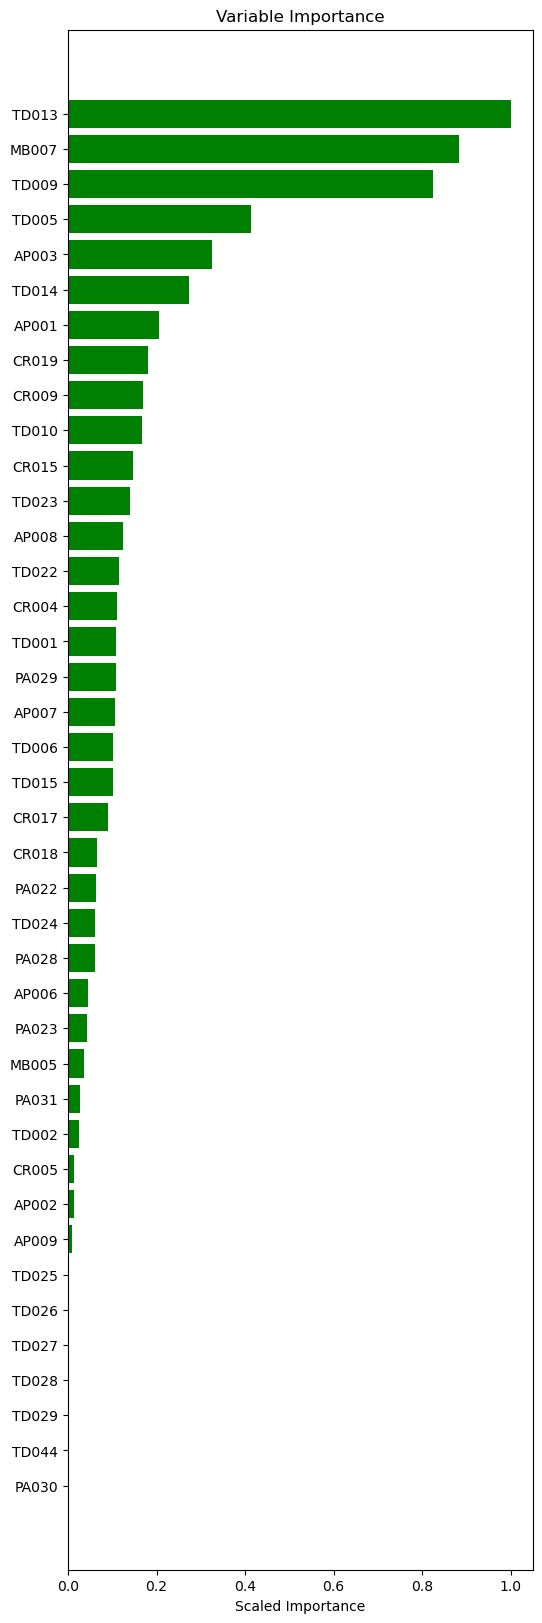

In [17]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [18]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.274792
1,0,0.155529
2,0,0.120041
3,0,0.230445
4,0,0.120385


In [19]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,91,229,640,191,449,0.32,0.17,120.0,1.59,15.0,29.84
2,320,78,242,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,59,261,1280,328,952,0.55,0.37,240.0,1.37,18.0,25.62
4,320,63,257,1600,391,1209,0.65,0.46,300.0,1.30,19.0,24.44
5,320,54,266,1920,445,1475,0.74,0.57,360.0,1.24,17.0,23.18
6,320,40,280,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,56,264,2560,541,2019,0.90,0.78,480.0,1.13,12.0,21.13
8,320,34,286,2880,575,2305,0.96,0.89,540.0,1.06,7.0,19.97


### Interpretation:
- Take the first decile (0): There are 320 instances, and the model predicted 100 actual positive cases. The cumulative percentage of actual positive cases at this point is 0.17%, which is higher than the expected random percentage of 0.08%. The lift is 1.67, indicating that this decile is 1.67 times more likely to contain actual positive cases than random chance.

In [20]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



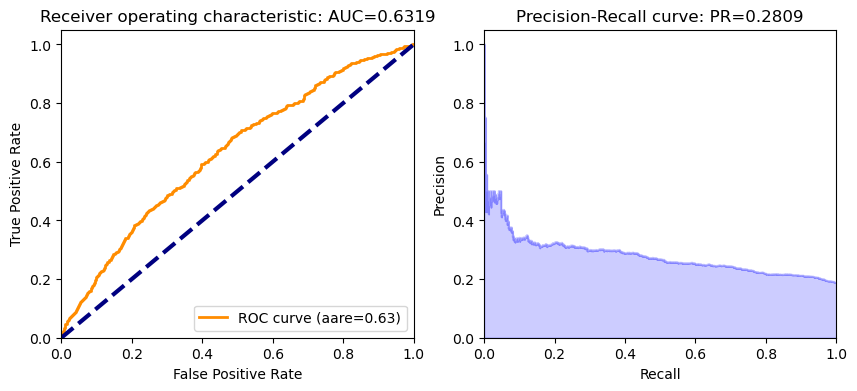

In [21]:
ROC_AUC(rf_v1,test_hex,'loan_default')

# Best Model Using Grid-Search

In [36]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,15 hours 48 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_vickyma_rxjfot
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,678 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [41]:
rf_params1 = {'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate_per_tree': [0.2, 0.5, 1.0],
                'ntrees' : [100,200,300]
                #'min_rows' :[50,100]
               }

rf_model = H2ORandomForestEstimator()#nfolds=10, min_rows=100, balance_classes=True, seed=1234

# Perform grid search
grid = H2OGridSearch(rf_model, rf_params1)
grid.train(x=predictors, y=target, training_frame=train_hex)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate_per_tree,max_depth,ntrees,sample_rate,model_ids,residual_deviance
,0.2,5.0,300.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_22,0.1482217
,0.2,5.0,100.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_4,0.1482793
,0.5,5.0,300.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_23,0.1483928
,0.2,9.0,300.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_25,0.1484326
,0.2,9.0,200.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_16,0.1485371
,0.5,5.0,200.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_14,0.1485387
,1.0,5.0,200.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_15,0.1485524
,0.2,5.0,200.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_13,0.1485965
,1.0,5.0,300.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_24,0.1486787
,0.2,3.0,300.0,0.8,Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_19,0.1487143


In [42]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
def ROC_AUC_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    return roc_auc

def PR_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    average_precision = average_precision_score(y_actual,y_pred)
    return average_precision

ROC_AUC_index(grid.get_grid()[0],test_hex,'loan_default')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.6297474358974359

In [44]:
best_roc_index = 0
best_pr_index = 0
best_roc_auc = 0
best_pr_score = 0
for i in range(len(grid.get_grid())):
  inter_grid=grid.get_grid()[i]

# Evaluate ROC AUC
  roc_auc = ROC_AUC_index(inter_grid, test_hex, target)
  if roc_auc > best_roc_auc:
      best_roc_auc = roc_auc
      best_roc_index = i

# Evaluate PR index
  pr_score = PR_index(inter_grid, test_hex, target)
  if pr_score > best_pr_score:
      best_pr_score = pr_score
      best_pr_index = i

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

In [45]:
# Print the results
print("Best PR Index:", best_pr_index)
print("Best PR Score:", best_pr_score)

Best PR Index: 46
Best PR Score: 0.2742625562903985


In [46]:
best_rf_model = grid.get_grid()[46]
best_rf_model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: Grid_DRF_Key_Frame__upload_9a2f0b1f54f276aafa823d0bcb114155.hex_model_python_1701310331368_4_model_47


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         50222                  3            3            3             7             8             7.95667

ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-11-30 13:10:55  2 min 22.556 sec  0                  nan              nan             nan

Variable Importances: 
variable    relative_importance    scaled_importance      percentage
----------  ---------------------  ---------------------  ---------------------
TD013       1561.990234375         1.0                    0.20813871866307007
MB007       1051.5545654296875     0.6732145581245882     0.1401220155133767
TD009       976.2847290039062      0.6250261413411126     0.1300921401896621
TD005       693.07080078125        0.44371007291128733    0.09235324603365273
AP003       390.5816345214844      0.2500538261545329     0.052045882972602556
TD014       369.3778991699219      0.23647900674470046    0.04922043745455745
PA029       246.21543884277344     0.15762930742092107    0.03280876207033767
TD010       209.3697509765625      0.13404037129613536    0.027898991130699772
TD023       187.80902099609375     0.12023700075899763    0.025025975273868347
CR015       180.71881103515625     0.11569778546500796    0.02408118881884153
---         ---                    ---                    ---
TD002       12.087532997131348     0.007738545818737425   0.0016106910110274663
CR018       2.836514949798584      0.0018159620254819071  0.0003779720091245975
AP002       0.0                    0.0                    0.0
AP009       0.0                    0.0                    0.0
TD025       0.0                    0.0                    0.0
TD026       0.0                    0.0                    0.0
TD027       0.0                    0.0                    0.0
TD028       0.0                    0.0                    0.0
TD029       0.0                    0.0                    0.0
TD044       0.0                    0.0                    0.0
[40 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [47]:
createGains(best_rf_model)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,102,218,320,102,218,0.17,0.08,60.0,1.70,9.0,31.87
1,320,81,239,640,183,457,0.30,0.18,120.0,1.52,12.0,28.59
2,320,75,245,960,258,702,0.43,0.27,180.0,1.43,16.0,26.88
3,320,64,256,1280,322,958,0.54,0.37,240.0,1.34,17.0,25.16
4,320,63,257,1600,385,1215,0.64,0.47,300.0,1.28,17.0,24.06
5,320,49,271,1920,434,1486,0.72,0.57,360.0,1.21,15.0,22.60
6,320,54,266,2240,488,1752,0.81,0.67,420.0,1.16,14.0,21.79
7,320,46,274,2560,534,2026,0.89,0.78,480.0,1.11,11.0,20.86
8,320,37,283,2880,571,2309,0.95,0.89,540.0,1.06,6.0,19.83


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



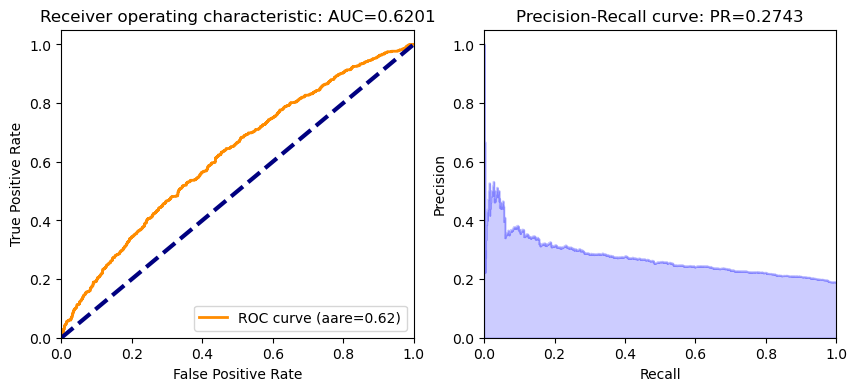

In [48]:
ROC_AUC(best_rf_model,test_hex,'loan_default')

In [55]:
best_rf_model_params = best_rf_model.params
max_depth_value = best_rf_model_params['max_depth']['actual']
sample_rate_value = best_rf_model_params['sample_rate']['actual']
col_sample_rate_value = best_rf_model_params['col_sample_rate_per_tree']['actual']
ntrees_value = best_rf_model_params['ntrees']['actual']
min_rows = best_rf_model_params['min_rows']['actual']
print("max depth =",max_depth_value)
print ("sample rate =", sample_rate_value)
print("col sample rate =", col_sample_rate_value)
print("ntrees =", ntrees_value)
print("min_rows =", min_rows)

max depth = 3
sample rate = 1.0
col sample rate = 0.5
ntrees = 300
min_rows = 1.0


### Now the code works fine with the small dataset, we can model with the entire dataset

In [22]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         107997                 6            11           7.66          19            25            22.45

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14767353573534184
RMSE: 0.38428314526575563
MAE: 0.2957980576763411
RMSLE: 0.2694211114439255
Mean Residual Deviance: 0.14767353573534184

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1477604099297664
RMSE: 0.3843961627406892
MAE: 0.29597600286172465
RMSLE: 0.26950533579774466
Mean Residual Deviance: 0.1477604099297664

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.295862  0.0105649   0.289865      0.288422      0.298811      0.300648      0.292843      0.314834      0.285189      0.299015      0.280622      0.30837
mean_residual_deviance  0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
mse                     0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
r2                      0.028792  0.0137831   0.00862054    0.0396453     0.0410812     0.0347524     0.0503409     0.0253746     0.0139032     0.0120922     0.0286377     0.0334718
residual_deviance       0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
rmse                    0.383921  0.0152529   0.375468      0.376155      0.389945      0.39179       0.382246      0.409737      0.36397       0.386362      0.362004      0.401536
rmsle                   0.269315  0.00791244  0.265959      0.264117      0.271659      0.273025      0.267234      0.283091      0.260066      0.272064      0.257598      0.278338

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-29 21:15:56  32.946 sec  0.0                nan                  nan                  nan
     2023-11-29 21:15:56  32.971 sec  1.0                0.3920307054589556   0.296256731487853    0.1536880740226464
     2023-11-29 21:15:56  32.988 sec  2.0                0.3942032053571326   0.29700516758134304  0.15539616711383766
     2023-11-29 21:15:56  33.000 sec  3.0                0.3904279147638411   0.2939797914789087   0.15243395662684114
     2023-11-29 21:15:56  33.013 sec  4.0                0.3901756870847142   0.2949471374634921   0.1522370667920288
     2023-11-29 21:15:56  33.026 sec  5.0                0.39045233521620937  0.29677616864784884  0.15245302607579111
     2023-11-29 21:15:56  33.049 sec  6.0                0.38983582738116856  0.2966234733230358   0.15197197230996023
     2023-11-29 21:15:57  33.069 sec  7.0                0.38914318695596034  0.2966341661783077   0.1514324199542415
     2023-11-29 21:15:57  33.086 sec  8.0                0.3882353582921885   0.295444631963733    0.150726693428264
     2023-11-29 21:15:57  33

In [23]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,91,229,640,191,449,0.32,0.17,120.0,1.59,15.0,29.84
2,320,78,242,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,59,261,1280,328,952,0.55,0.37,240.0,1.37,18.0,25.62
4,320,63,257,1600,391,1209,0.65,0.46,300.0,1.30,19.0,24.44
5,320,54,266,1920,445,1475,0.74,0.57,360.0,1.24,17.0,23.18
6,320,40,280,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,56,264,2560,541,2019,0.90,0.78,480.0,1.13,12.0,21.13
8,320,34,286,2880,575,2305,0.96,0.89,540.0,1.06,7.0,19.97


In [24]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         107999                 6            11           7.66          19            25            22.45

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14767353573534184
RMSE: 0.38428314526575563
MAE: 0.2957980576763411
RMSLE: 0.2694211114439255
Mean Residual Deviance: 0.14767353573534184

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1477604099297664
RMSE: 0.3843961627406892
MAE: 0.29597600286172465
RMSLE: 0.26950533579774466
Mean Residual Deviance: 0.1477604099297664

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.295862  0.0105649   0.289865      0.288422      0.298811      0.300648      0.292843      0.314834      0.285189      0.299015      0.280622      0.30837
mean_residual_deviance  0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
mse                     0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
r2                      0.028792  0.0137831   0.00862054    0.0396453     0.0410812     0.0347524     0.0503409     0.0253746     0.0139032     0.0120922     0.0286377     0.0334718
residual_deviance       0.147605  0.0117422   0.140976      0.141493      0.152057      0.153499      0.146112      0.167884      0.132474      0.149275      0.131047      0.161231
rmse                    0.383921  0.0152529   0.375468      0.376155      0.389945      0.39179       0.382246      0.409737      0.36397       0.386362      0.362004      0.401536
rmsle                   0.269315  0.00791244  0.265959      0.264117      0.271659      0.273025      0.267234      0.283091      0.260066      0.272064      0.257598      0.278338

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-29 21:16:27  25.240 sec  0.0                nan                  nan                  nan
     2023-11-29 21:16:27  25.251 sec  1.0                0.3920307054589556   0.296256731487853    0.1536880740226464
     2023-11-29 21:16:27  25.261 sec  2.0                0.3942032053571326   0.29700516758134304  0.15539616711383766
     2023-11-29 21:16:27  25.272 sec  3.0                0.3904279147638411   0.2939797914789087   0.15243395662684114
     2023-11-29 21:16:27  25.284 sec  4.0                0.3901756870847142   0.2949471374634921   0.1522370667920288
     2023-11-29 21:16:27  25.295 sec  5.0                0.39045233521620937  0.29677616864784884  0.15245302607579111
     2023-11-29 21:16:27  25.305 sec  6.0                0.38983582738116856  0.2966234733230358   0.15197197230996023
     2023-11-29 21:16:27  25.316 sec  7.0                0.38914318695596034  0.2966341661783077   0.1514324199542415
     2023-11-29 21:16:27  25.324 sec  8.0                0.3882353582921885   0.295444631963733    0.150726693428264
     2023-11-29 21:16:27  25

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



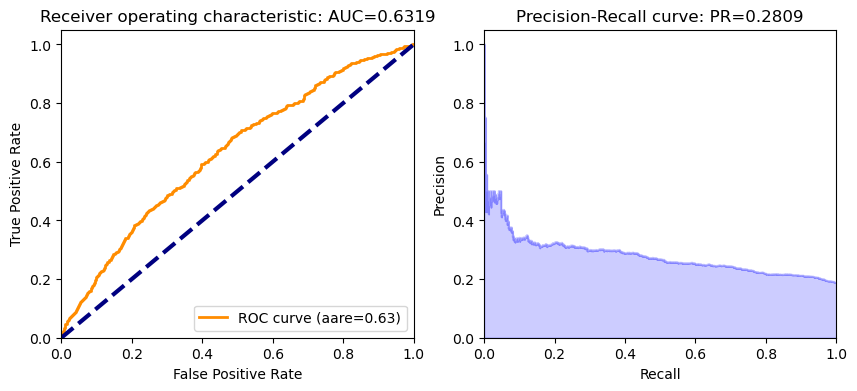

In [25]:
ROC_AUC(rf_v3,test_hex,'loan_default')

In [26]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,91,229,640,191,449,0.32,0.17,120.0,1.59,15.0,29.84
2,320,78,242,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,59,261,1280,328,952,0.55,0.37,240.0,1.37,18.0,25.62
4,320,63,257,1600,391,1209,0.65,0.46,300.0,1.30,19.0,24.44
5,320,54,266,1920,445,1475,0.74,0.57,360.0,1.24,17.0,23.18
6,320,40,280,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,56,264,2560,541,2019,0.90,0.78,480.0,1.13,12.0,21.13
8,320,34,286,2880,575,2305,0.96,0.89,540.0,1.06,7.0,19.97


### Interpretations:

1. Decile Analysis:

- In the first decile, I have 320 instances, and the model predicted 100 actual positive cases. The lift is 1.67, indicating that this decile is 1.67 times more likely to contain actual positive cases than random chance.
- The K-S value of 9.0 suggests decent discrimination between positive and negative cases.

2. Variable Importance:

- "TD013" is the most important variable. This means that changes in "TD013" have the most significant impact on the model's predictions.

3. Scoring History:

- The training process involved building 300 trees.
- AUC is 0.6319, indicating some level of discrimination between positive and negative instances.

# UnderSampling

Undersampling involves reducing the number of instances in the majority class to balance it with the minority class. It randomly remove instances from the majority class until the class distribution is more balanced. It helps prevent the model from being dominated by the majority class, allowing it to pay more attention to the minority class. Undersampling is useful when the majority class has redundant or similar instances.


In [43]:
y = data[target]
X = data.drop(target,axis=1)
y.dtypes

dtype('int64')

In [44]:
y1_cnt = data[target].sum()
y1_cnt

15488

In [45]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

30976

In [46]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [47]:
from imblearn.datasets import make_imbalance
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt , 0:  y0_cnt},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs)   

In [48]:
y_rs = data[data[target]==1]
X_rs = data[data[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [49]:
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         940756                 12           18           14.1267       211           230           220.027

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20668949969901124
RMSE: 0.45463116886000154
MAE: 0.4162627495128115
RMSLE: 0.31945204775804414
Mean Residual Deviance: 0.20668949969901124

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.20679165228476326
RMSE: 0.4547435016410496
MAE: 0.4165702095886562
RMSLE: 0.31953450833066077
Mean Residual Deviance: 0.20679165228476326

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.416581   0.00299037  0.418453      0.420658      0.413266      0.411697      0.415703      0.415477      0.415695      0.418938      0.420548      0.415376
mean_residual_deviance  0.2068     0.00277504  0.208698      0.2105        0.203805      0.202405      0.205916      0.205765      0.206437      0.209219      0.210324      0.204934
mse                     0.2068     0.00277504  0.208698      0.2105        0.203805      0.202405      0.205916      0.205765      0.206437      0.209219      0.210324      0.204934
r2                      0.0693031  0.00499591  0.0673524     0.0665574     0.0737517     0.075186      0.0705541     0.0762884     0.0690327     0.0608904     0.0632287     0.0701896
residual_deviance       0.2068     0.00277504  0.208698      0.2105        0.203805      0.202405      0.205916      0.205765      0.206437      0.209219      0.210324      0.204934
rmse                    0.454744   0.00305153  0.456834      0.458803      0.451448      0.449895      0.453779      0.453613      0.454354      0.457404      0.458611      0.452696
rmsle                   0.319536   0.00158491  0.320265      0.321401      0.317807      0.316954      0.319332      0.318537      0.319199      0.321219      0.321688      0.318963

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-21 13:48:11  9 min 33.473 sec   0.0                nan                  nan                  nan
     2023-11-21 13:48:11  9 min 33.662 sec   1.0                0.46484004143657126  0.4160695253162338   0.2160762641227533
     2023-11-21 13:48:11  9 min 33.846 sec   2.0                0.46336123642169724  0.4161814671418938   0.21470363541824403
     2023-11-21 13:48:11  9 min 34.024 sec   3.0                0.4621725462427433   0.4166387352240995   0.21360346250050066
     2023-11-21 13:48:12  9 min 34.203 sec   4.0                0.4616116794434578   0.4171187973479355   0.21308534259860967
     2023-11-21 13:48:12  9 min 34.412 sec   5.0                0.4608833739148114   0.41721164993504434  0.21241348435109986
     2023-11-21 13:48:12  9 min 34.593 sec   6.0                0.46028156942015114  0.4173186526812139   0.2118591231478774
     2023-11-21 13:48:12  9 min 34.790 sec   7.0                0.459369522808057    0.41699953429800796  0.21102035848490197
     2023-11-21 13:48:13  9 min 35.265 sec   8.0            

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



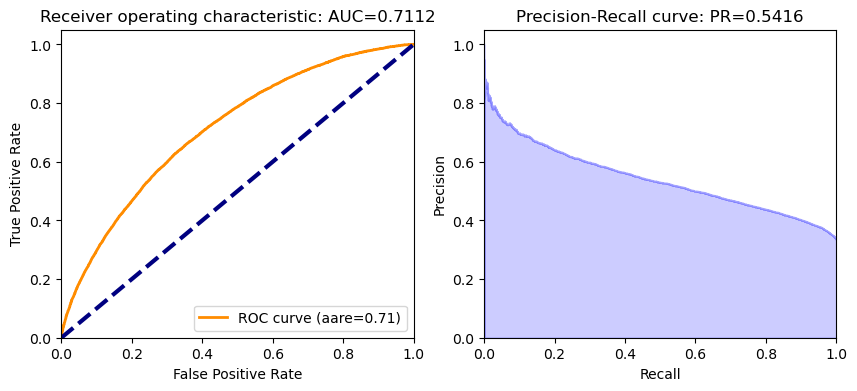

In [50]:
ROC_AUC(rf_v4,smpl_hex,'loan_default')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



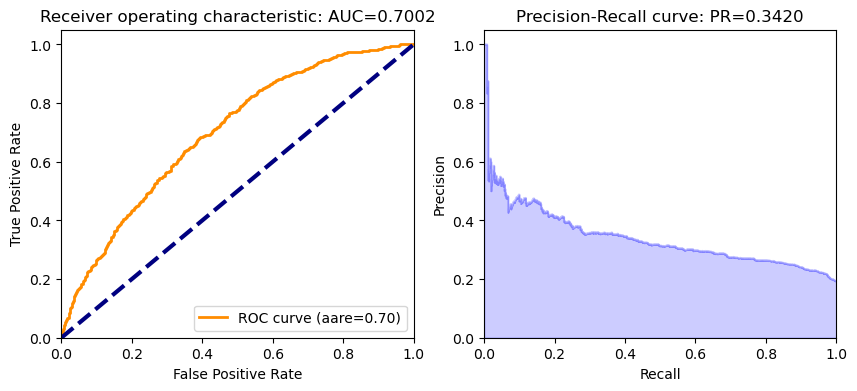

In [51]:
ROC_AUC(rf_v4,test_hex,'loan_default')

In [52]:
createGains(rf_v4)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,131,189,320,131,189,0.22,0.07,60.0,2.18,15.0,40.94
1,320,95,225,640,226,414,0.38,0.16,120.0,1.88,22.0,35.31
2,320,74,246,960,300,660,0.50,0.25,180.0,1.67,25.0,31.25
3,320,78,242,1280,378,902,0.63,0.35,240.0,1.58,28.0,29.53
4,320,56,264,1600,434,1166,0.72,0.45,300.0,1.45,27.0,27.12
5,320,62,258,1920,496,1424,0.83,0.55,360.0,1.38,28.0,25.83
6,320,43,277,2240,539,1701,0.90,0.65,420.0,1.28,25.0,24.06
7,320,32,288,2560,571,1989,0.95,0.76,480.0,1.19,19.0,22.30
8,320,18,302,2880,589,2291,0.98,0.88,540.0,1.09,10.0,20.45


### Interpretations:

1. Decile Analysis:

- In the first decile, I have 320 instances, and the model predicted 131 actual positive cases. The lift is 2.18, indicating that this decile is 2.18 times more likely to contain actual positive cases than random chance.
- The K-S value of 15.0 suggests decent discrimination between positive and negative cases.

2. Variable Importance:

- "TD013" is the most important variable. This means that changes in "TD013" have the most significant impact on the model's predictions.

3. Scoring History:

- The training process involved building 300 trees.
- AUC is 0.7002, indicating some level of discrimination between positive and negative instances.

# OverSampling

Oversampling involves increasing the number of instances in the minority class to balance it with the majority class. It duplicates existing instances in the minority class or generating synthetic instances using techniques like SMOTE (Synthetic Minority Over-sampling Technique). It helps the model better learn the patterns in the minority class by providing more instances for training. Oversampling is useful when the minority class has limited data.

In [57]:
from imblearn.over_sampling import RandomOverSampler
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:10000 , 0:  40000},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs)   

In [58]:
y_rs = data[data[target]==1]
X_rs = data[data[target]==0].sample(n=40000)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [59]:
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v5.train(predictors,target,training_frame=smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.12291e+06            13           18           14.9933       252           276           262.903

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.18863254385265102
RMSE: 0.43431848205280305
MAE: 0.3794216886191135
RMSLE: 0.3050170892164021
Mean Residual Deviance: 0.18863254385265102

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1885904992544311
RMSE: 0.4342700763976619
MAE: 0.3795123184785811
RMSLE: 0.304985743054387
Mean Residual Deviance: 0.1885904992544311

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.379514   0.00325543  0.383505      0.385967      0.377806      0.38099       0.377882      0.3753        0.379665      0.379754      0.376465      0.377805
mean_residual_deviance  0.188592   0.00314539  0.192596      0.194626      0.18702       0.189957      0.187543      0.184348      0.188992      0.188655      0.185606      0.186575
mse                     0.188592   0.00314539  0.192596      0.194626      0.18702       0.189957      0.187543      0.184348      0.188992      0.188655      0.185606      0.186575
r2                      0.0625221  0.00457454  0.0585802     0.0582015     0.0662686     0.0590192     0.0682615     0.0576335     0.0660258     0.0614522     0.0600749     0.0697038
residual_deviance       0.188592   0.00314539  0.192596      0.194626      0.18702       0.189957      0.187543      0.184348      0.188992      0.188655      0.185606      0.186575
rmse                    0.434258   0.00361259  0.438857      0.441165      0.432458      0.43584       0.433062      0.429358      0.434733      0.434344      0.43082       0.431943
rmsle                   0.304982   0.00178102  0.307377      0.308427      0.303886      0.306035      0.303914      0.303239      0.304808      0.305133      0.303544      0.303454

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-21 14:09:43  14 min 53.648 sec  0.0                nan                  nan                  nan
     2023-11-21 14:09:44  14 min 53.786 sec  1.0                0.44044464804651756  0.3770995678825967   0.1939914879928207
     2023-11-21 14:09:44  14 min 53.923 sec  2.0                0.4400241685331004   0.3781702997894806   0.19362126889324635
     2023-11-21 14:09:44  14 min 54.046 sec  3.0                0.4398843368270424   0.3784504011288074   0.1934982297857669
     2023-11-21 14:09:44  14 min 54.160 sec  4.0                0.439531714106506    0.37900529489926543  0.19318812770540333
     2023-11-21 14:09:44  14 min 54.287 sec  5.0                0.4395732338025469   0.3794405784569185   0.19322462787562858
     2023-11-21 14:09:44  14 min 54.411 sec  6.0                0.4388922374411245   0.3795178833020582   0.1926263960860764
     2023-11-21 14:09:44  14 min 54.533 sec  7.0                0.43831153847116866  0.3796767364092284   0.19211700475696278
     2023-11-21 14:09:44  14 min 54.698 sec  8.0                0.

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



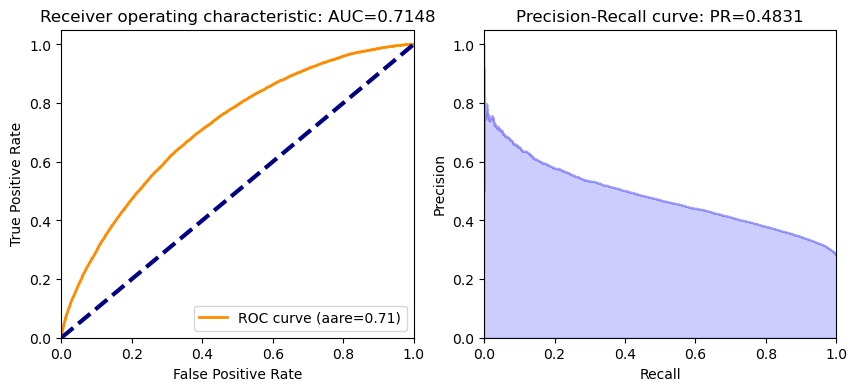

In [60]:
ROC_AUC(rf_v5,smpl_hex,'loan_default')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



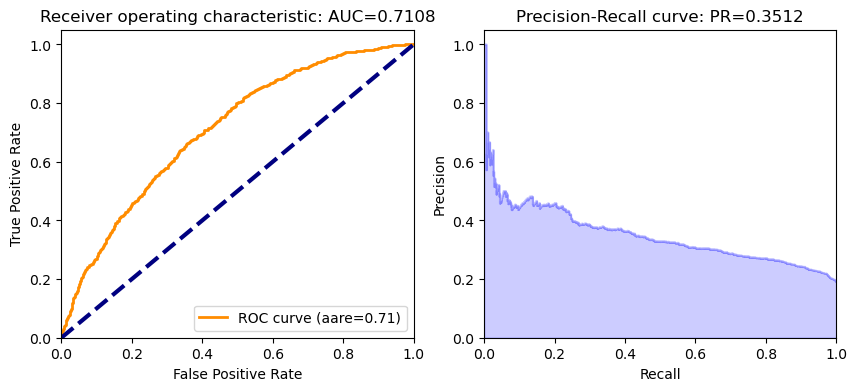

In [61]:
ROC_AUC(rf_v5,test_hex,'loan_default')

In [62]:
createGains(rf_v5)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,139,181,320,139,181,0.23,0.07,60.0,2.32,16.0,43.44
1,320,96,224,640,235,405,0.39,0.16,120.0,1.96,23.0,36.72
2,320,78,242,960,313,647,0.52,0.25,180.0,1.74,27.0,32.60
3,320,73,247,1280,386,894,0.64,0.34,240.0,1.61,30.0,30.16
4,320,58,262,1600,444,1156,0.74,0.44,300.0,1.48,30.0,27.75
5,320,59,261,1920,503,1417,0.84,0.55,360.0,1.40,29.0,26.20
6,320,39,281,2240,542,1698,0.90,0.65,420.0,1.29,25.0,24.20
7,320,31,289,2560,573,1987,0.96,0.76,480.0,1.19,20.0,22.38
8,320,16,304,2880,589,2291,0.98,0.88,540.0,1.09,10.0,20.45


### Interpretations:

1. Decile Analysis:

- In the first decile, I have 320 instances, and the model predicted 139 actual positive cases. The lift is 2.32, indicating that this decile is 2.32 times more likely to contain actual positive cases than random chance.
- The K-S value of 16.0 suggests decent discrimination between positive and negative cases.

2. Variable Importance:

- "TD013" is the most important variable. This means that changes in "TD013" have the most significant impact on the model's predictions.

3. Scoring History:

- The training process involved building 300 trees.
- AUC is 0.7108, indicating some level of discrimination between positive and negative instances.

# Summary:
1. Both undersampling and oversampling has improved the model accuracy by approximately 30%
2. Among the 5 models, model 5 with oversampling technique has the best performance with lift of 2.32, K_S 16.0 and AUC of 0.7108